# Підготовка до виконання проекту

In [ ]:
import zipfile

with zipfile.ZipFile('Animals-10.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/animals10')

1. Перевірка структури та підготовка середовища

In [25]:
import os
from pathlib import Path

dataset_path = Path('/content/animals10/raw-img')

# Dictionary for class translation: Italian → English
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}

classes = sorted([folder.name for folder in dataset_path.iterdir() if folder.is_dir()])
translated_classes = [translate[cls] for cls in classes]
print("Classes:", translated_classes)

Classes: ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']


2. Підрахунок зображень у кожному класі

In [26]:
for cls in classes:
    img_count = len(list((dataset_path / cls).glob('*')))
    print(f"{translate[cls]}: {img_count} images")

dog: 4863 images
horse: 2623 images
elephant: 1446 images
butterfly: 2112 images
chicken: 3098 images
cat: 1668 images
cow: 1866 images
sheep: 1820 images
spider: 4821 images
squirrel: 1862 images


3. Розділення на train / val / test

In [29]:
from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil

def prepare_splits(base_dir, output_dir, val_ratio=0.15, test_ratio=0.15):
    base_dir = Path(base_dir)
    output_dir = Path(output_dir)

    # Create output folders with translated names
    for split in ['train', 'val', 'test']:
        for it_name, en_name in translate.items():
            (output_dir / split / en_name).mkdir(parents=True, exist_ok=True)

    # Process each Italian class
    for it_name, en_name in translate.items():
        source_folder = base_dir / it_name
        if not source_folder.exists():
            print(f"Source folder not found for class '{it_name}'")
            continue

        images = list(source_folder.glob('*'))

        if len(images) == 0:
            print(f"No images found for class '{it_name}'")
            continue

        # Step 3: Split into train, val, test
        train_imgs, temp_imgs = train_test_split(
            images, test_size=val_ratio + test_ratio, random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs, test_size=test_ratio / (val_ratio + test_ratio), random_state=42
        )

        # Step 4: Copy images to destination folders (translated names)
        for img in train_imgs:
            shutil.copy(img, output_dir / 'train' / en_name / img.name)
        for img in val_imgs:
            shutil.copy(img, output_dir / 'val' / en_name / img.name)
        for img in test_imgs:
            shutil.copy(img, output_dir / 'test' / en_name / img.name)

        print(f"Processed '{it_name}' → '{en_name}': "
              f"{len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

    print("Dataset successfully split and translated.")

prepare_splits('/content/animals10/raw-img', '/content/dataset_split')


Processed 'cane' → 'dog': 3404 train, 729 val, 730 test
Processed 'cavallo' → 'horse': 1836 train, 393 val, 394 test
Processed 'elefante' → 'elephant': 1012 train, 217 val, 217 test
Processed 'farfalla' → 'butterfly': 1478 train, 317 val, 317 test
Processed 'gallina' → 'chicken': 2168 train, 465 val, 465 test
Processed 'gatto' → 'cat': 1167 train, 250 val, 251 test
Processed 'mucca' → 'cow': 1306 train, 280 val, 280 test
Processed 'pecora' → 'sheep': 1274 train, 273 val, 273 test
Processed 'ragno' → 'spider': 3374 train, 723 val, 724 test
Processed 'scoiattolo' → 'squirrel': 1303 train, 279 val, 280 test
Dataset successfully split and translated.


4. Формат файлів

In [31]:
import PIL

example = list((dataset_path / classes[0]).glob('*'))[0]
img = PIL.Image.open(example)
print("Size:", img.size)
print("Format:", img.format)
img.show()

Size: (225, 300)
Format: JPEG


 5. Перетворення зображень у тензори + аугментація

In [32]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformation pipeline for training set with data augmentation
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize all images to 128x128
    transforms.RandomHorizontalFlip(),         # Randomly flip images horizontally
    transforms.RandomRotation(10),             # Random rotation up to ±10 degrees
    transforms.ToTensor(),                     # Convert PIL Image to PyTorch tensor
    transforms.Normalize([0.5], [0.5])          # Normalize pixel values to range [-1, 1]
])

# Define transformation pipeline for validation and test sets (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),             # Resize images
    transforms.ToTensor(),                     # Convert to tensor
    transforms.Normalize([0.5], [0.5])          # Normalize
])

# Load the datasets using ImageFolder
train_dataset = ImageFolder('/content/dataset_split/train', transform=transform_train)
val_dataset = ImageFolder('/content/dataset_split/val', transform=transform_test)
test_dataset = ImageFolder('/content/dataset_split/test', transform=transform_test)


6. DataLoader

In [34]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


 7. Візуалізація зображень з класами

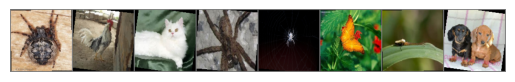

Labels: ['spider', 'chicken', 'cat', 'spider', 'spider', 'butterfly', 'spider', 'dog']


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to denormalize and display a batch of images
def imshow(img):
    img = img / 2 + 0.5            # Denormalize (reverse normalization)
    npimg = img.numpy()           # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Change channel order for display
    plt.axis('off')
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the first 8 images from the batch
imshow(torchvision.utils.make_grid(images[:8]))

print('Labels:', [train_dataset.classes[label] for label in labels[:8]])


8. Гістограма розподілу класів

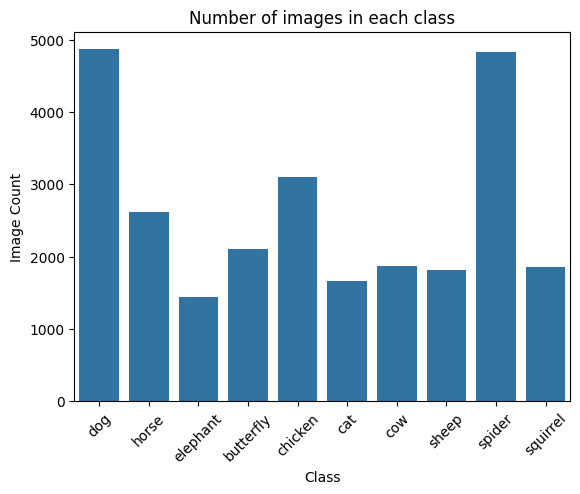

In [37]:
import seaborn as sns
import pandas as pd

# List to store image counts per class
counts = []

for cls in classes:
    num = len(list((dataset_path / cls).glob('*')))
    translated_name = translate[cls]  # Translate class name to English
    counts.append({'class': translated_name, 'count': num})

# Create DataFrame for plotting
df = pd.DataFrame(counts)

# Plot class distribution as a bar chart
sns.barplot(data=df, x='class', y='count')
plt.xticks(rotation=45)
plt.title("Number of images in each class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.show()


**Планування наступного етапу:**

**Метрики ефективності моделі:**

*   Accuracy — частка правильних передбачень;
*   Precision — точність передбачень для кожного класу;
*   Recall — повнота виявлення правильних об’єктів;
*   F1-score — баланс між precision і recall;
*   Confusion matrix — покаже, що з чим модель плутає.

**Запланована архітектура нейронної мережі:**

*   Кількість згорткових шарів: 2–3;
*   Кількість фільтрів: 32 → 64 → 128;
*   Активація: ReLU після кожного згорткового шару;
*   Pooling: MaxPooling2D після кожного другого шару;
*   Dropout: 0.3–0.5 для запобігання перенавчанню;
*   Flatten після згорток і pooling;
*   Кількість повнозв’язаних шарів: 1–2 (наприклад: 256 → 10);
*   Фінальна активація: Softmax;
*   Оптимізатор: Adam;
*   Функція втрат: CrossEntropyLoss (багатокласова класифікація).